# 1. Data import
## 1.1 Load libraries

In [1]:
library(xcms)
library(faahKO)
library(RColorBrewer)
library(pander)
library(pheatmap)
library(MsExperiment)
library(magrittr)
library(SummarizedExperiment)


Le chargement a n'ecessit'e le package : BiocParallel

Le chargement a n'ecessit'e le package : MSnbase

Le chargement a n'ecessit'e le package : BiocGenerics


Attachement du package : 'BiocGenerics'


Les objets suivants sont masqu'es depuis 'package:stats':

    IQR, mad, sd, var, xtabs


Les objets suivants sont masqu'es depuis 'package:base':

    Filter, Find, Map, Position, Reduce, anyDuplicated, aperm, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, setdiff, sort, table,
    tapply, union, unique, unsplit, which.max, which.min


Le chargement a n'ecessit'e le package : Biobase

Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.


## 1.2 Get mzML file path and create a phenodata

In [2]:
mzML_directory <- "Aging_trail"
sample_groups <- list.dirs(mzML_directory,full.names = FALSE)[-1]
mzMLfiles <- dir(mzML_directory, full.names = TRUE, recursive = TRUE)
# print(mzMLfiles)
pd <- data.frame(sample_name = sub(basename(mzMLfiles),pattern = ".mzML",
                                    replacement = "", fixed = TRUE),
                 sample_group = c(rep("KO",3),rep("WT",3)),
                 stringsAsFactors = FALSE)
pd

sample_name,sample_group
<chr>,<chr>
KO-week16-2_21_01_13664,KO
KO-week52-4_35_01_13695,KO
KO-week8-1_8_01_13669,KO
WT-week16-3_16_01_13681,WT
WT-week52-2_27_01_13677,WT
WT-week8-3_4_01_13671,WT


## 1.3 Read data

In [13]:
library(Spectra)
data <- readMsExperiment(mzMLfiles, sampleData = pd)
data

Object of class MsExperiment 
 Spectra: MS1 (7410) MS2 (15463) 
 Experiment data: 6 sample(s)
 Sample data links:
  - spectra: 6 sample(s) to 22873 element(s).

In [4]:
spectra(data)

MSn data (Spectra) with 22873 spectra in a MsBackendMzR backend:
        msLevel     rtime scanIndex
      <integer> <numeric> <integer>
1             1     0.821         1
2             2     1.225         2
3             2     1.556         3
4             1     1.893         4
5             2     2.336         5
...         ...       ...       ...
22869         2   1260.39      3788
22870         2   1260.72      3789
22871         1   1261.06      3790
22872         2   1261.43      3791
22873         2   1261.76      3792
 ... 33 more variables/columns.

file(s):
KO-week16-2_21_01_13664.mzML
KO-week52-4_35_01_13695.mzML
KO-week8-1_8_01_13669.mzML
 ... 3 more files

In [5]:
sampleData(data)

DataFrame with 6 rows and 3 columns
    sample_name sample_group spectraOrigin
    <character>  <character>   <character>
1 KO-week16-...           KO /Users/buk...
2 KO-week52-...           KO /Users/buk...
3 KO-week8-1...           KO /Users/buk...
4 WT-week16-...           WT /Users/buk...
5 WT-week52-...           WT /Users/buk...
6 WT-week8-3...           WT /Users/buk...

# 2. initial data inspection

## 2.1 inspect BPC

In [14]:
data <- filterRt(data, rt =c(120,1080))

Filter spectra



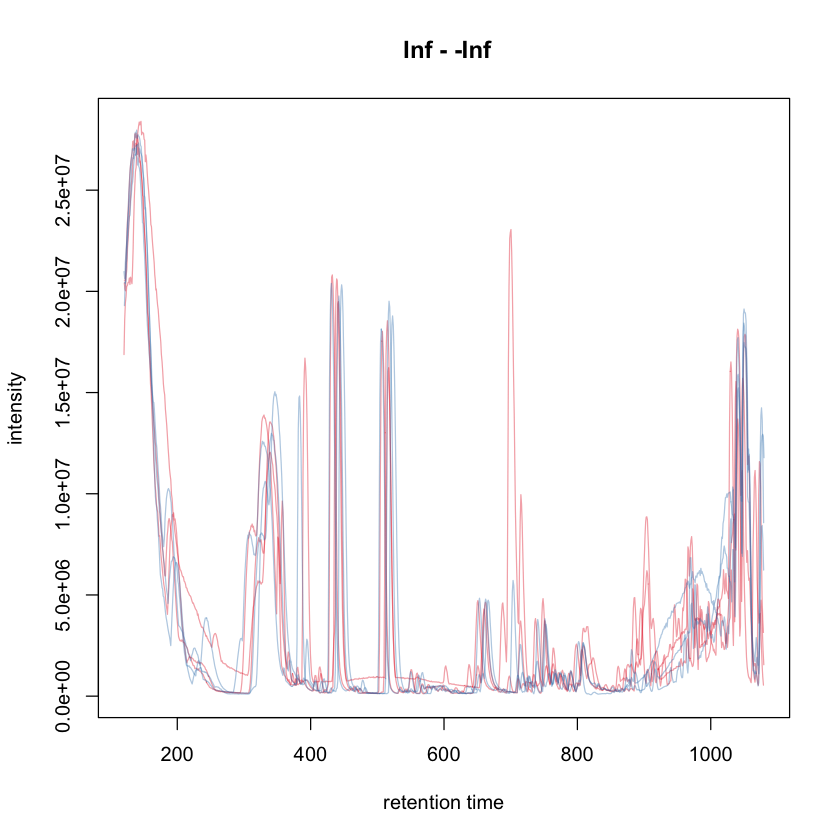

In [8]:
# Get the base peak chromatograms.
bpcs <- chromatogram(data,aggregationFun = 'max')
# plot all chromatograms
group_colors <- paste0(brewer.pal(3,"Set1")[1:2],"60")
names(group_colors) <- c("KO","WT")
#png(file = "plot/bpc_test.png")
plot(bpcs, col = group_colors[sampleData(data)$sample_group])

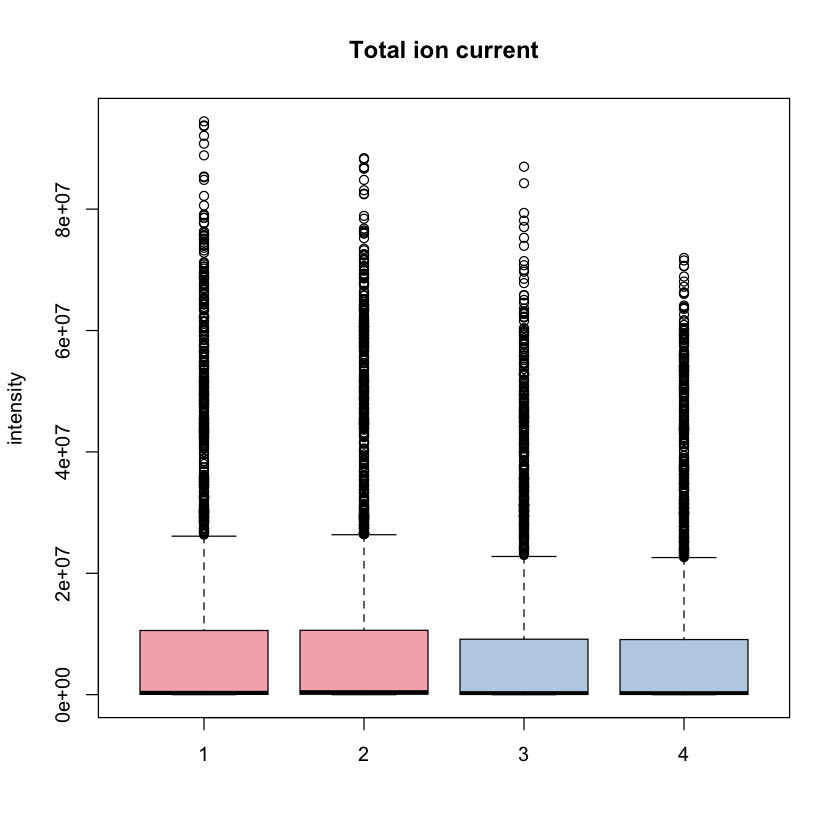

In [8]:
# get the TIC by file
tc <- split(tic(raw_data), f = fromFile(raw_data))
boxplot(tc, col = group_colors[raw_data$sample_group],
        ylab = "intensity", main = "Total ion current")

In [6]:
# Bin the BPC
bpcs_bin <- MSnbase::bin(bpcs,binSize = 2)
cormat <- cor(log2(do.call(cbind, lapply(bpcs_bin, intensity))))
colnames(cormat) <- rownames(cormat) <- raw_data$sample_name

## Define which phenodata columns should be highlighted in the plot
ann <- data.frame(group = raw_data$sample_group)
rownames(ann) <- raw_data$sample_name

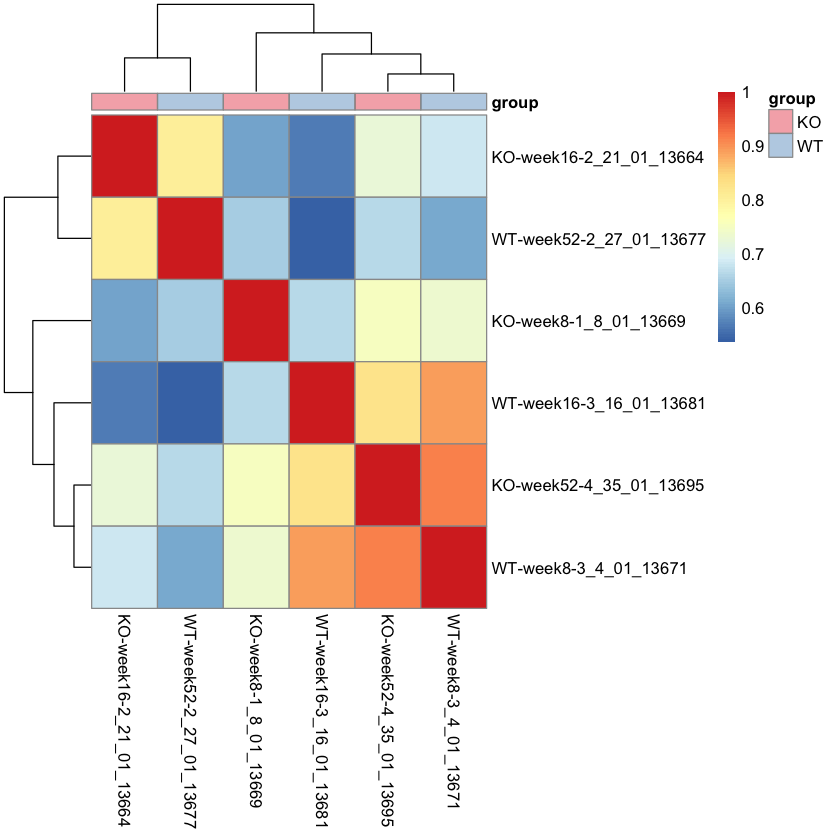

In [7]:
# Perform the cluster analysis
pheatmap(cormat, annotation = ann,
         annotation_color = list(group = group_colors))

# 3. Peak picking

## 3.1 inspect centWave parameters with known peaks

In [11]:
# inspect peakwidth and mass deviation with IS
# eg. 3.3
# rtr <- c(2700, 2900)
# mzr <- c(334.9, 335.1)
# ## extract the chromatogram
# chr_raw <- chromatogram(raw_data, mz = mzr, rt = rtr)
# plot(chr_raw, col = group_colors[chr_raw$sample_group])

# raw_data %>%
#     filterRt(rt = rtr) %>%
#     filterMz(mz = mzr) %>%
#     plot(type = "XIC")

# xchr <- findChromPeaks(chr_raw,param = CentWaveParam(snthresh = 3))
# head(chromPeaks(xchr))
# chromPeakData(xchr)
# sample_colors <- group_colors[xchr$sample_group]
# plot(xchr, col = sample_colors,
#      peakBg = sample_colors[chromPeaks(xchr)[, "column"]])

In [15]:
# 3.2 peak picking
cwp <- CentWaveParam(peakwidth = c(20,80),
                     prefilter = c(3, 5000),
                     snthresh = 100,
                     ppm = 10)
xdata <- findChromPeaks(data,
                        param = cwp)

In [16]:
head(chromPeaks(xdata))

,mz,mzmin,mzmax,rt,rtmin,rtmax,into,intb,maxo,sn,sample
CP00001,115.0669,115.0661,115.0677,123.816,120.731,128.594,32395.56,32387.70,6314,6313,1
CP00002,416.9946,416.9932,416.9970,122.735,120.731,128.594,47276.29,47222.98,17565,248,1
CP00003,540.0995,540.0975,540.1010,122.735,120.731,128.594,44464.28,44456.42,12515,12514,1
CP00004,647.1114,647.1075,647.1144,123.816,120.731,128.594,35398.24,35390.38,6493,6492,1
CP00005,662.1113,662.1101,662.1124,122.735,120.731,128.594,83424.46,83344.75,34573,327,1
CP00006,808.1537,808.1523,808.1553,122.735,120.731,128.594,90052.97,90045.11,31806,31805,1


## 3.2 refine peak (TODO: CleanPeakPara)

In [17]:
# Merge neighboring peaks(signal lower than 75% of the highest peak, with 4s of RT)
mpp <- MergeNeighboringPeaksParam(expandRt = 4)
xdata_pp <- refineChromPeaks(xdata,mpp)

Reduced from 12577 to 12384 chromatographic peaks.



### pre-file summary

In [18]:
xdata <- xdata_pp
# summarize chromatographic peaks
summary_fun <- function(z)
    c(peak_count = nrow(z), rt = quantile(z[, "rtmax"] - z[, "rtmin"]))

T <- lapply(split.data.frame(
    chromPeaks(xdata), f = chromPeaks(xdata)[, "sample"]),
    FUN = summary_fun)
T <- do.call(rbind, T)
rownames(T) <- basename(fileNames(xdata))
pandoc.table(
    T,
    caption = paste0("Summary statistics on identified chromatographic",
                     " peaks. Shown are number of identified peaks per",
                     " sample and widths/duration of chromatographic ",
                     "peaks."))



|              &nbsp;              | peak_count | rt.0% | rt.25% | rt.50% |
|:--------------------------------:|:----------:|:-----:|:------:|:------:|
| **KO-week16-2_21_01_13664.mzML** |    1988    | 3.73  | 13.87  | 23.85  |
| **KO-week52-4_35_01_13695.mzML** |    2077    | 7.898 | 15.82  | 25.64  |
|  **KO-week8-1_8_01_13669.mzML**  |    2577    | 7.826 | 13.66  | 20.98  |
| **WT-week16-3_16_01_13681.mzML** |    1810    | 7.302 | 14.96  | 24.75  |
| **WT-week52-2_27_01_13677.mzML** |    2032    | 1.023 | 15.96  | 25.25  |
|  **WT-week8-3_4_01_13671.mzML**  |    1900    | 7.653 | 14.74  | 24.42  |

Table: Summary statistics on identified chromatographic peaks. Shown are number of identified peaks per sample and widths/duration of chromatographic peaks. (continued below)

 

|              &nbsp;              | rt.75% | rt.100% |
|:--------------------------------:|:------:|:-------:|
| **KO-week16-2_21_01_13664.mzML** | 37.91  |   229   |
| **KO-week52-4_35_01_13695.mzML** | 36.82

### ISTD check (TODO)

##### test

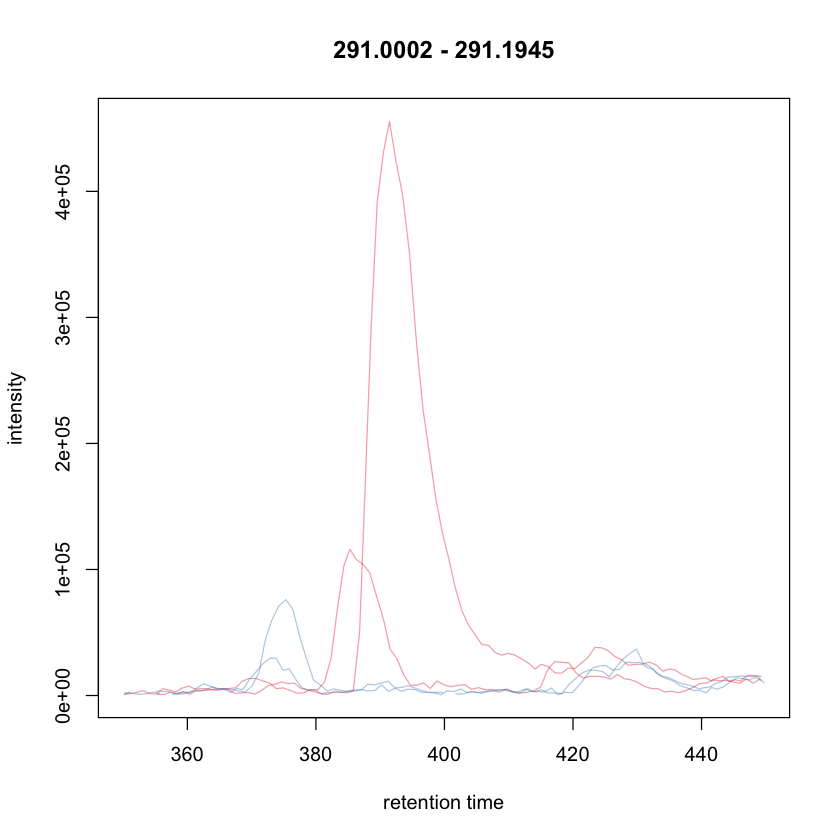

In [18]:
# test feature detection
rt_ref <- c(350,450)
mz_ref <- c(291.0,291.2)
# extract the chromatogram
chr_raw <- chromatogram(raw_data, mz = mz_ref, rt = rt_ref)
plot(chr_raw, col = group_colors[chr_raw$sample_group])

Warning message in trimMz_Spectrum(object, mzlim = mz, msLevel. = msLevel., ...):
"No data points between 291 and 291.2 for spectrum with acquisition
number 1116. Returning empty spectrum."
Warning message in trimMz_Spectrum(object, mzlim = mz, msLevel. = msLevel., ...):
"No data points between 291 and 291.2 for spectrum with acquisition
number 1122. Returning empty spectrum."
Warning message in trimMz_Spectrum(object, mzlim = mz, msLevel. = msLevel., ...):
"No data points between 291 and 291.2 for spectrum with acquisition
number 1125. Returning empty spectrum."
Warning message in trimMz_Spectrum(object, mzlim = mz, msLevel. = msLevel., ...):
"No data points between 291 and 291.2 for spectrum with acquisition
number 1122. Returning empty spectrum."
Warning message in trimMz_Spectrum(object, mzlim = mz, msLevel. = msLevel., ...):
"No data points between 291 and 291.2 for spectrum with acquisition
number 1106. Returning empty spectrum."
Warning message in trimMz_Spectrum(object, mzlim =

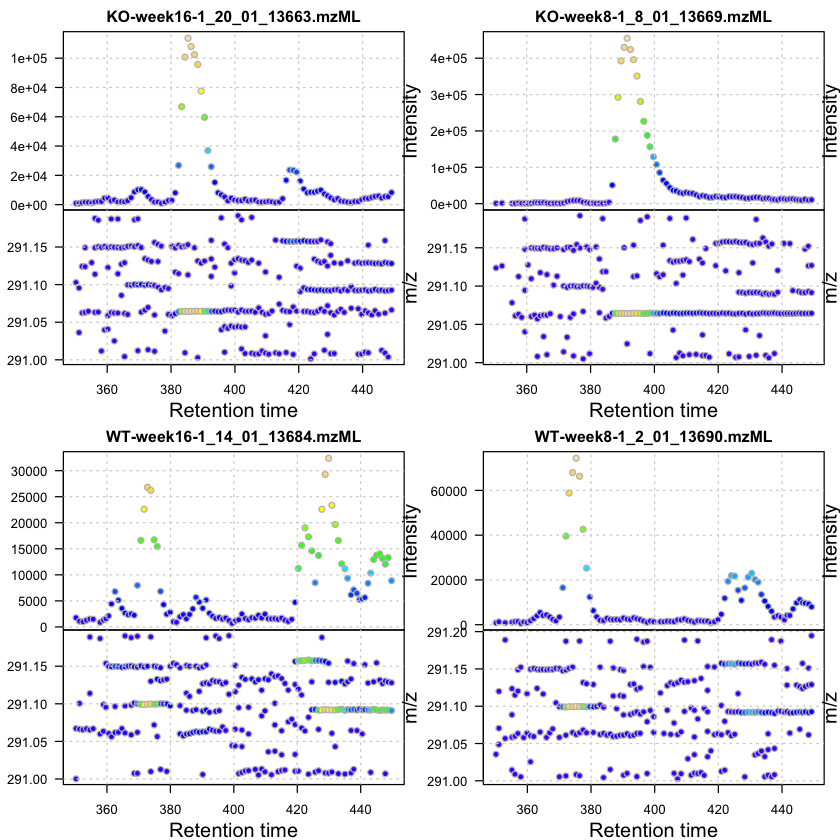

In [19]:
raw_data %>%
    filterRt(rt = rt_ref) %>%
    filterMz(mz = mz_ref) %>%
    plot(type = "XIC")

rt,rtmin,rtmax,into,intb,maxo,sn,row,column
387.329,367.504,405.264,1091952.1,746023.5,116094,8,1,1
393.470,374.658,413.064,4696541.4,3618951.8,455562,6,1,2
427.757,407.767,444.994,474770.0,219137.2,36838,2,1,3
375.330,357.030,395.459,579212.3,359478.0,75999,8,1,4


DataFrame with 4 rows and 4 columns
   ms_level is_filled       row    column
  <integer> <logical> <integer> <integer>
1         1     FALSE         1         1
2         1     FALSE         1         2
3         1     FALSE         1         3
4         1     FALSE         1         4

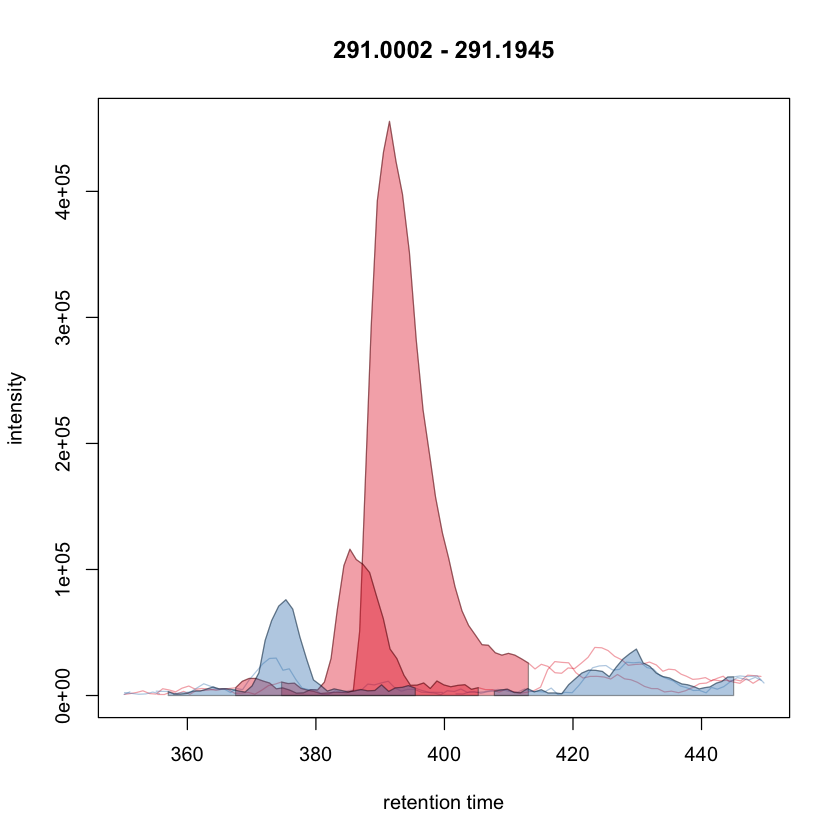

In [20]:
xchr <- findChromPeaks(chr_raw,param = CentWaveParam(snthresh = 3))
head(chromPeaks(xchr))
chromPeakData(xchr)
sample_colors <- group_colors[xchr$sample_group]
plot(xchr, col = sample_colors,
     peakBg = sample_colors[chromPeaks(xchr)[, "column"]])

## Check peak deteaction results with IS

In [21]:
chr_ex <- chromatogram(xdata, mz = mz_ref, rt = rt_ref)
chromPeaks(chr_ex)

,mz,mzmin,mzmax,rt,rtmin,rtmax,into,intb,maxo,sn,sample,row,column
CP0277,291.0644,291.0613,291.0655,387.329,369.608,406.372,915237.7,907613.3,113582,163,1,1,1
CP2794,291.0644,291.0640,291.0650,393.470,374.658,413.064,4599787.6,4579698.4,454641,340,2,1,2
CP5059,291.0996,291.0991,291.1001,373.821,368.593,379.937,150506.0,150495.7,26813,26812,3,1,3
CP5114,291.1575,291.1570,291.1583,423.537,419.329,428.815,103794.8,103786.3,19028,19027,3,1,3
CP6878,291.0994,291.0989,291.0996,375.330,368.979,381.787,441303.9,441292.2,74337,74336,4,1,4


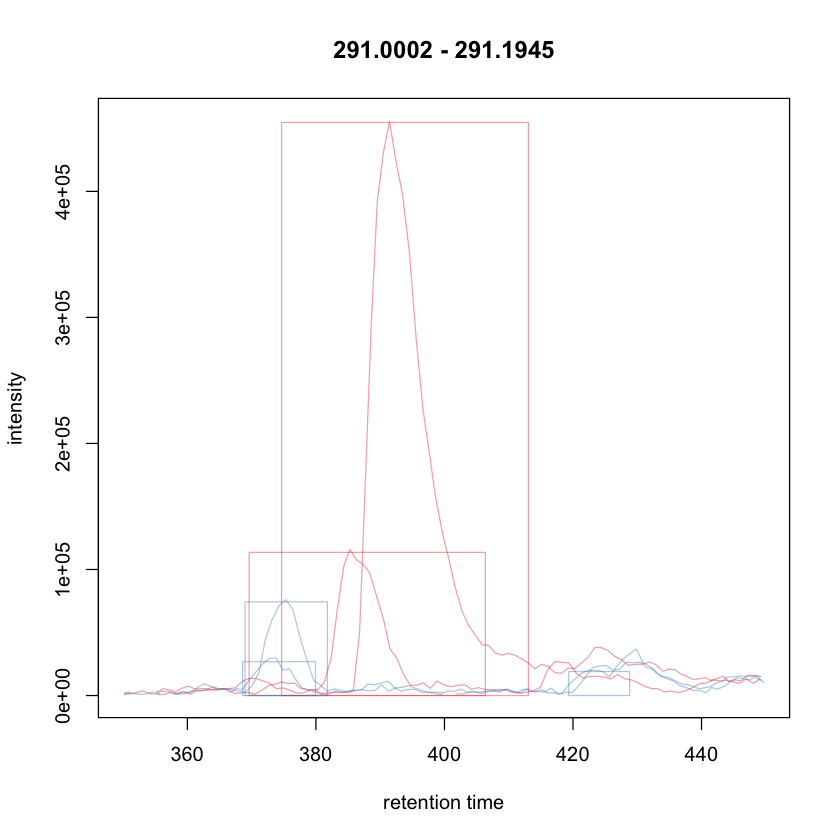

In [22]:
sample_colors <- group_colors[chr_ex$sample_group]
plot(chr_ex, col = sample_colors,peakType = "rectangle",
    peakCol = sample_colors[chromPeaks(chr_ex)[, "sample"]],
    peakBg = NA)

# 4. Alignment

In [19]:
xdata <-adjustRtime(xdata,param = ObiwarpParam(binSize = 0.6))


In [20]:
head(adjustedRtime(xdata))

[1] 138.6730 138.9380 139.2760 139.3913 139.4743 139.6063

In [26]:
sample_colors <- group_colors[sampleData(data)$sample_group]

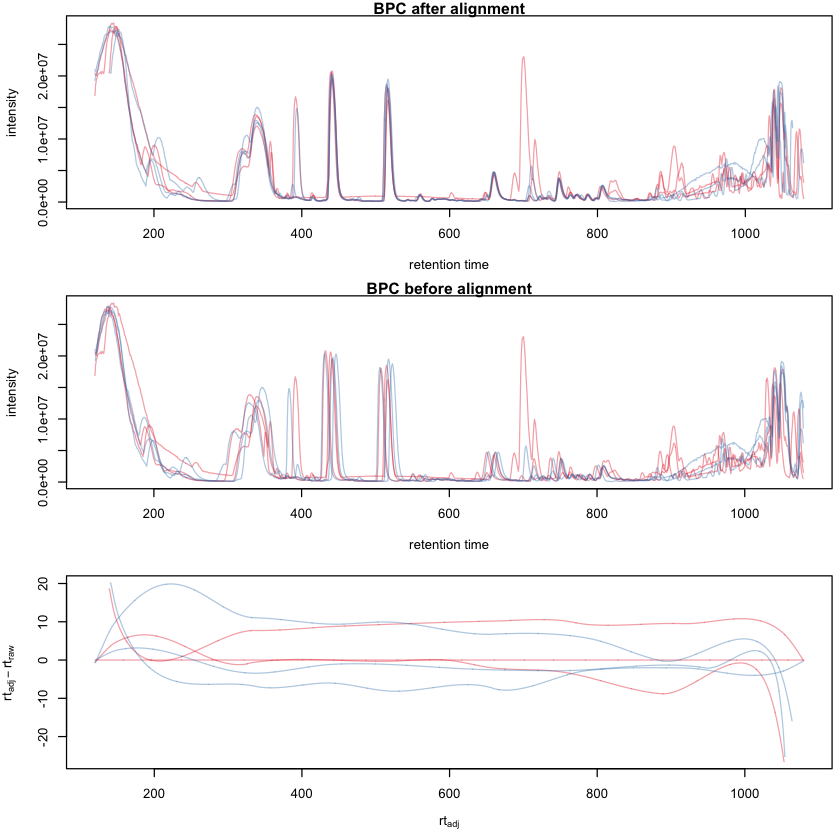

In [29]:
bpcs_adj <- chromatogram(xdata,aggregationFun = 'max', chromPeaks ="none")
par(mfrow = c(3,1),mar = c(4.5, 4.2, 1, 0.5))
plot(bpcs_adj, col = sample_colors,
     main = "BPC after alignment")
plot(bpcs, col = sample_colors,
     main = "BPC before alignment")
plotAdjustedRtime(xdata, col = sample_colors)

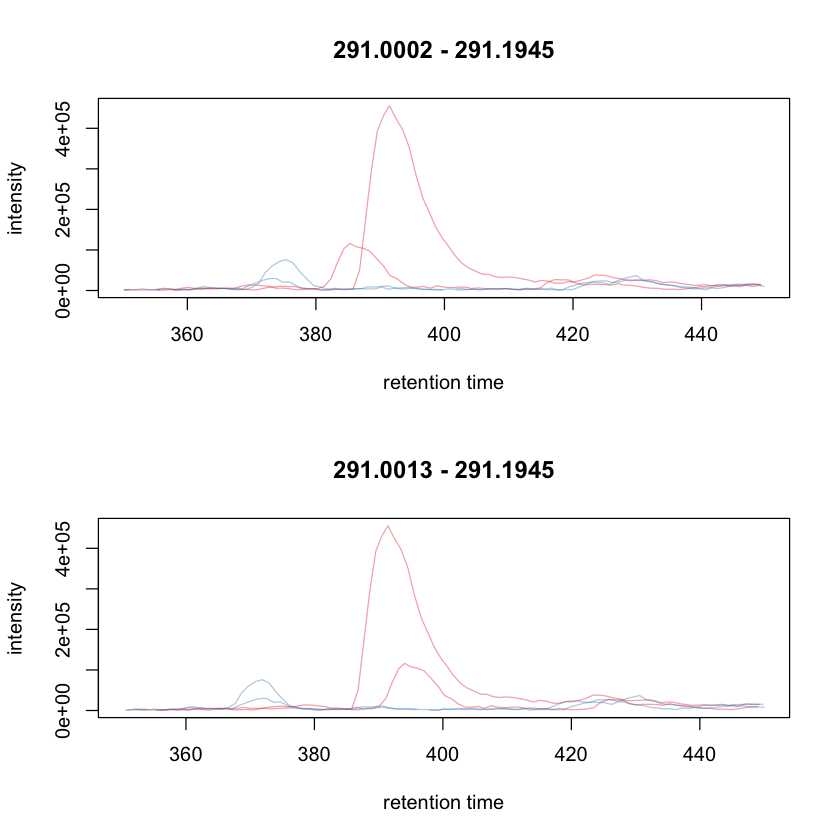

In [26]:
par(mfrow = c(2,1))
plot(chr_raw, col = group_colors[chr_raw$sample_group])

chr_adj <- chromatogram(xdata, mz = mz_ref, rt = rt_ref)
plot(chr_adj, col = group_colors[chr_raw$sample_group], peakType = "none")

# 5. Grouping

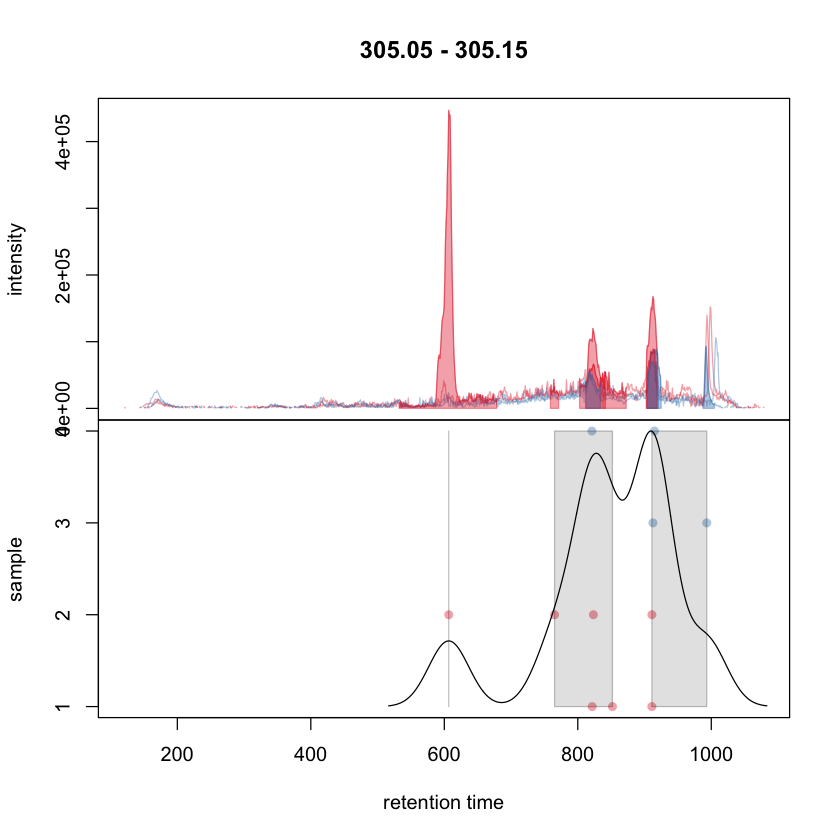

In [27]:
## Define the mz slice.
mzr_grouping <- c(305.05, 305.15)

## Extract and plot the chromatograms
chr_mzr <- chromatogram(xdata, mz = mzr_grouping)
## Define the parameters for the peak density method
pdp <- PeakDensityParam(sampleGroups = xdata$sample_group,
                        minFraction = 0.4, bw = 30)
plotChromPeakDensity(chr_mzr, col = sample_colors, param = pdp,
                     peakBg = sample_colors[chromPeaks(chr_mzr)[, "sample"]],
                     peakCol = sample_colors[chromPeaks(chr_mzr)[, "sample"]],
                     peakPch = 16)

In [31]:
## Perform the correspondence
pdp <- PeakDensityParam(sampleGroups = sampleData(xdata)$sample_group,
                        minFraction = 0.4, bw = 30)
xdata <- groupChromPeaks(xdata, param = pdp)

In [32]:
xdata <- fillChromPeaks(xdata,param = ChromPeakAreaParam())

In [33]:
str(xdata)

Formal class 'XcmsExperiment' [package "xcms"] with 11 slots
  ..@ chromPeaks        : num [1:15065, 1:11] 115 417 540 647 662 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr [1:15065] "CP00001" "CP00002" "CP00003" "CP00004" ...
  .. .. ..$ : chr [1:11] "mz" "mzmin" "mzmax" "rt" ...
  ..@ chromPeakData     :'data.frame':	15065 obs. of  3 variables:
  .. ..$ ms_level : int [1:15065] 1 1 1 1 1 1 1 1 1 1 ...
  .. ..$ is_filled: logi [1:15065] FALSE FALSE FALSE FALSE FALSE FALSE ...
  .. ..$ merged   : logi [1:15065] FALSE FALSE FALSE FALSE FALSE FALSE ...
  ..@ featureDefinitions:'data.frame':	1850 obs. of  11 variables:
  .. ..$ mzmed   : num [1:1850] 64 69 69.1 72.1 73.1 ...
  .. ..$ mzmin   : num [1:1850] 64 69 69.1 72.1 73.1 ...
  .. ..$ mzmax   : num [1:1850] 64 69 69.1 72.1 73.1 ...
  .. ..$ rtmed   : num [1:1850] 170 228 323 169 170 ...
  .. ..$ rtmin   : num [1:1850] 164 221 321 164 164 ...
  .. ..$ rtmax   : num [1:1850] 173 230 325 173 173 ...
  .. ..$ npeaks  : num

In [34]:
## Missing values before filling in peaks
apply(featureValues(xdata, filled = FALSE), MARGIN = 2,
      FUN = function(z) sum(is.na(z)))

KO-week16-2_21_01_13664.mzML KO-week52-4_35_01_13695.mzML 
                         456                          484 
  KO-week8-1_8_01_13669.mzML WT-week16-3_16_01_13681.mzML 
                         442                          511 
WT-week52-2_27_01_13677.mzML   WT-week8-3_4_01_13671.mzML 
                         603                          493

In [35]:
## Missing values after filling in peaks
apply(featureValues(xdata), MARGIN = 2,
      FUN = function(z) sum(is.na(z)))

KO-week16-2_21_01_13664.mzML KO-week52-4_35_01_13695.mzML 
                          64                           68 
  KO-week8-1_8_01_13669.mzML WT-week16-3_16_01_13681.mzML 
                          39                           33 
WT-week52-2_27_01_13677.mzML   WT-week8-3_4_01_13671.mzML 
                          54                           50

In [36]:
head(featureSummary(xdata, group = sampleData(xdata)$sample_group))

,count,perc,multi_count,multi_perc,rsd,KO_count,KO_perc,KO_multi_count,KO_multi_perc,KO_rsd,WT_count,WT_perc,WT_multi_count,WT_multi_perc,WT_rsd
FT0001,4,66.66667,0,0,0.03432006,1,33.33333,0,0,NA,3,100.00000,0,0,0.04193051
FT0002,3,50.00000,0,0,0.22814894,2,66.66667,0,0,0.11507622,1,33.33333,0,0,NA
FT0003,2,33.33333,0,0,0.02966607,0,0.00000,0,0,NA,2,66.66667,0,0,0.02966607
FT0004,6,100.00000,0,0,0.20766077,3,100.00000,0,0,0.26856093,3,100.00000,0,0,0.17339842
FT0005,5,83.33333,0,0,0.12350699,2,66.66667,0,0,0.04277277,3,100.00000,0,0,0.17260849
FT0006,4,66.66667,0,0,0.08550183,2,66.66667,0,0,0.02639904,2,66.66667,0,0,0.07989838


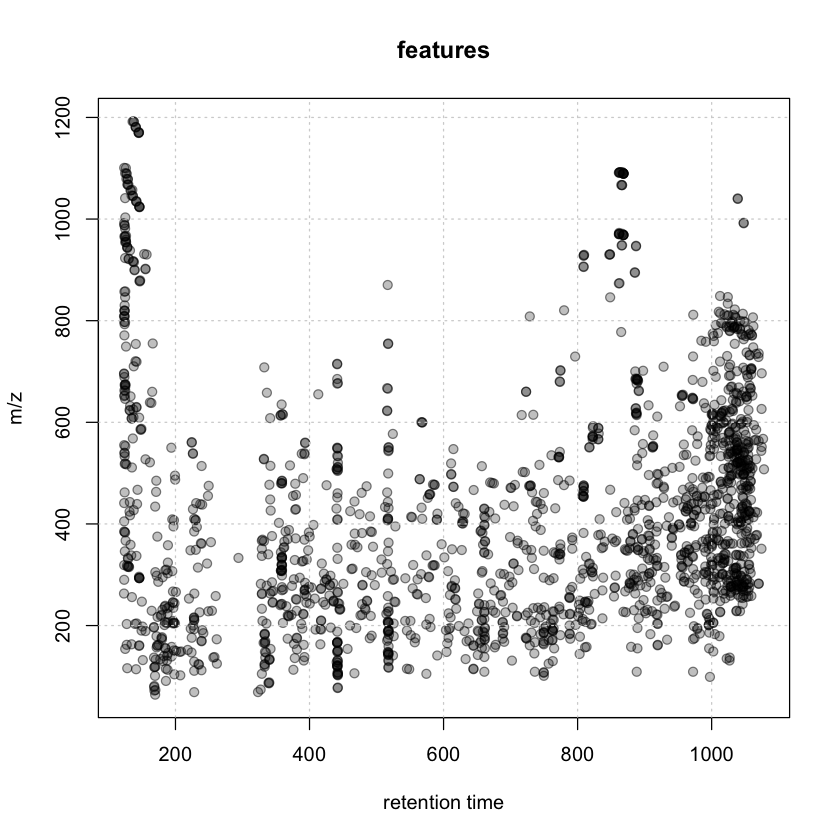

In [37]:
# feature grouping
library(MsFeatures)
plot(featureDefinitions(xdata)$rtmed, featureDefinitions(xdata)$mzmed,
     xlab = "retention time", ylab = "m/z", main = "features",
     col = "#00000080", pch = 21, bg = "#00000040")
grid()


In [42]:
xdata_group <- groupFeatures(xdata, param = SimilarRtimeParam(10))

In [43]:
table(featureGroups(xdata_group))


FG.0001 FG.0002 FG.0003 FG.0004 FG.0005 FG.0006 FG.0007 FG.0008 FG.0009 FG.0010 
      9       4      15       4       2       2       4       3       2       3 
FG.0011 FG.0012 FG.0013 FG.0014 FG.0015 FG.0016 FG.0017 FG.0018 FG.0019 FG.0020 
      8       5       5       2       3       3       6       4       4       2 
FG.0021 FG.0022 FG.0023 FG.0024 FG.0025 FG.0026 FG.0027 FG.0028 FG.0029 FG.0030 
      3       4       7       4       5       3       6       5       2       6 
FG.0031 FG.0032 FG.0033 FG.0034 FG.0035 FG.0036 FG.0037 FG.0038 FG.0039 FG.0040 
      5       4       3       2       2       4       3       6       3       3 
FG.0041 FG.0042 FG.0043 FG.0044 FG.0045 FG.0046 FG.0047 FG.0048 FG.0049 FG.0050 
      5       6       3       3       6       4       4       3       3       4 
FG.0051 FG.0052 FG.0053 FG.0054 FG.0055 FG.0056 FG.0057 FG.0058 FG.0059 FG.0060 
      3       3       2       4       4       6       5       2       5       4 
FG.0061 FG.0062 FG.0063 FG.

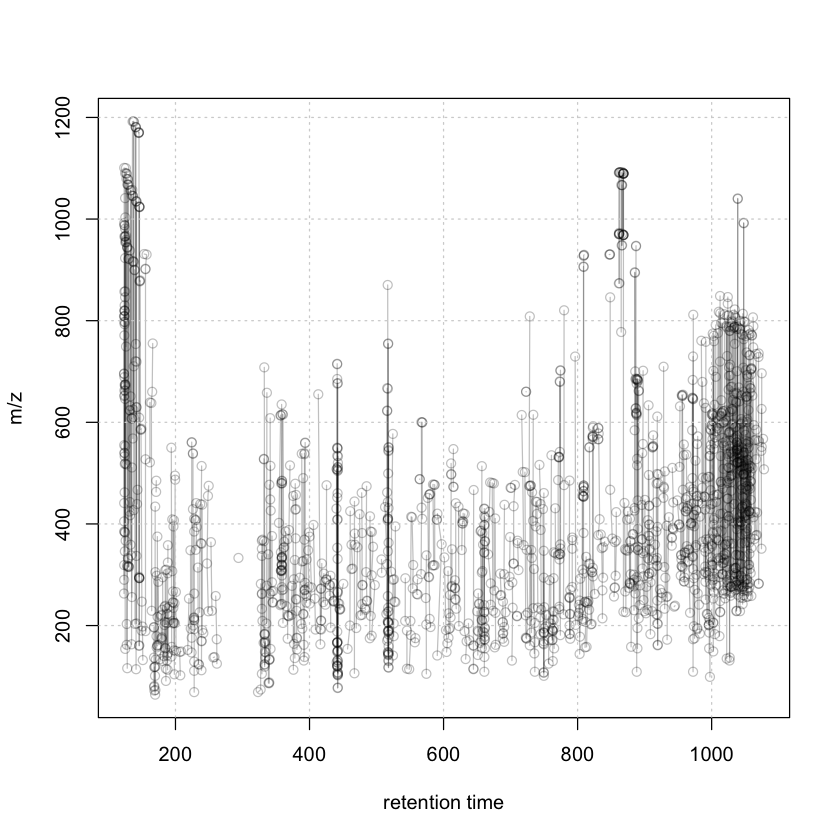

In [44]:
plotFeatureGroups(xdata_group, pch = 21, #lwd = 2, 
                  col = "#00000040",
                 # bg = "#00000020"
                  )
grid()

In [48]:
#save xcms data
save(xdata_group, file = "xcmsgouped_data.RData")

In [70]:
featuresDef <- featureDefinitions(xdata_group)
featuresDef

,mzmed,mzmin,mzmax,rtmed,rtmin,rtmax,npeaks,KO,WT,peakidx,ms_level,feature_group
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<list>,<int>,<chr>
FT0001,63.99653,63.99644,63.99659,169.6566,164.3862,173.2679,4,1,3,"195, 696....",1,FG.0365
FT0002,68.99580,68.99574,68.99582,227.9092,220.5841,229.9195,3,2,1,"207, 225....",1,FG.0001
FT0003,69.06858,69.06857,69.06859,323.1440,321.0388,325.2493,2,0,2,"7034, 87....",1,FG.0512
FT0004,72.07937,72.07928,72.07947,168.5002,164.2010,173.2679,6,3,3,"1553, 37....",1,FG.0002
FT0005,73.08273,73.08264,73.08281,170.0449,164.3862,173.2679,5,2,3,"137, 216....",1,FG.0274
FT0006,74.05867,74.05863,74.05869,327.0510,325.5174,330.0720,4,2,2,"715, 523....",1,FG.0512
FT0007,77.03712,77.03704,77.03722,441.8565,440.9531,442.4530,6,3,3,"486, 248....",1,FG.0003
FT0008,78.04066,78.04053,78.04069,442.3224,440.9531,442.4530,6,3,3,"446, 245....",1,FG.0004
FT0009,79.01966,79.01965,79.01975,168.0747,165.2262,173.2679,5,3,2,"900, 296....",1,FG.0055


In [71]:
featuresIntensities <- featureValues(xdata_group, value ="into")

In [72]:
featuresIntensities

,KO-week16-2_21_01_13664.mzML,KO-week52-4_35_01_13695.mzML,KO-week8-1_8_01_13669.mzML,WT-week16-3_16_01_13681.mzML,WT-week52-2_27_01_13677.mzML,WT-week8-3_4_01_13671.mzML
FT0001,1014512.96,923251.81,731158.68,1044335.87,969064.31,1041634.94
FT0002,448937.15,528469.91,154316.60,330754.67,264767.56,165172.64
FT0003,1189611.51,1039133.17,846584.46,1190101.87,1141198.01,953297.92
FT0004,30544496.50,28770727.37,17799735.39,34303114.10,24427173.46,27917548.52
FT0005,1465992.92,1379918.56,672311.50,1662858.43,1183607.92,1362566.37
FT0006,2347696.37,343756.11,2261653.90,2449482.13,369316.47,2742830.61
FT0007,842163.95,810525.92,695043.23,830558.68,791994.05,710415.75
FT0008,59043.81,55661.01,42734.20,59299.19,50497.31,48721.22
FT0009,46492768.24,40989565.84,32069526.40,22018228.15,43673903.16,47841518.99
FT0010,2368824.69,2103785.18,1659627.39,2535727.43,2235072.86,2465705.45


In [73]:
dataTable <- merge(featuresDef, featuresIntensities, by =0, all=TRUE)
dataTable <- dataTable[,!(names(dataTable) %in% c("peakidx"))]
write.table(dataTable, file = "aging_test.txt", sep = "\t",
            quote = FALSE, row.names = FALSE)

In [57]:
sps <- spectra(xdata_group)

In [76]:
head(chromPeaks(xdata_group))

,mz,mzmin,mzmax,rt,rtmin,rtmax,into,intb,maxo,sn,sample
CP00001,115.0669,115.0661,115.0677,140.7827,139.276,143.1473,32395.56,32387.70,6314,6313,1
CP00002,416.9946,416.9932,416.9970,140.2566,139.276,143.1473,47276.29,47222.98,17565,248,1
CP00003,540.0995,540.0975,540.1010,140.2566,139.276,143.1473,44464.28,44456.42,12515,12514,1
CP00004,647.1114,647.1075,647.1144,140.7827,139.276,143.1473,35398.24,35390.38,6493,6492,1
CP00005,662.1113,662.1101,662.1124,140.2566,139.276,143.1473,83424.46,83344.75,34573,327,1
CP00006,808.1537,808.1523,808.1553,140.2566,139.276,143.1473,90052.97,90045.11,31806,31805,1


In [77]:
sps_ms2 <- chromPeakSpectra(xdata_group,return.type = "Spectra")
sps_ms2

MSn data (Spectra) with 6844 spectra in a MsBackendMzR backend:
       msLevel     rtime scanIndex
     <integer> <numeric> <integer>
1            2   141.444       398
2            2   141.879       401
3            2   142.370       404
4            2   145.433       424
5            2   145.864       426
...        ...       ...       ...
6840         2   695.041      2084
6841         2   696.087      2087
6842         2   834.061      2481
6843         2   837.771      2492
6844         2   859.597      2553
 ... 34 more variables/columns.

file(s):
KO-week16-2_21_01_13664.mzML
KO-week52-4_35_01_13695.mzML
KO-week8-1_8_01_13669.mzML
 ... 3 more files
Processing:
 Filter: select retention time [120..1080] on MS level(s) 1 2 [Tue Aug  1 21:57:46 2023]
 Filter: select MS level(s) 2 [Wed Aug  2 10:26:02 2023]
 Filter: select MS level(s) 2 [Wed Aug  2 10:26:03 2023]
 ...2 more processings. Use 'processingLog' to list all. 

In [78]:
sps_ms2$peak_id

[1] "CP00113" "CP00113" "CP00113" "CP00113" "CP00113" "CP00143" "CP00143"
   [8] "CP00143" "CP00143" "CP00170" "CP00170" "CP00170" "CP00170" "CP00170"
  [15] "CP00170" "CP00174" "CP00174" "CP00174" "CP00249" "CP00249" "CP00249"
  [22] "CP00257" "CP00257" "CP00257" "CP00257" "CP00257" "CP00257" "CP00257"
  [29] "CP00260" "CP00260" "CP00260" "CP00260" "CP00260" "CP00260" "CP00262"
  [36] "CP00262" "CP00262" "CP00262" "CP00262" "CP00262" "CP00262" "CP00262"
  [43] "CP00262" "CP00262" "CP00262" "CP00262" "CP00262" "CP00262" "CP00269"
  [50] "CP00269" "CP00269" "CP00269" "CP00269" "CP00269" "CP00269" "CP00314"
  [57] "CP00314" "CP00314" "CP00314" "CP00314" "CP00314" "CP00314" "CP00314"
  [64] "CP00314" "CP00314" "CP00332" "CP00332" "CP00332" "CP00332" "CP00332"
  [71] "CP00332" "CP00353" "CP00353" "CP00353" "CP00353" "CP00353" "CP00353"
  [78] "CP00353" "CP00355" "CP00355" "CP00355" "CP00355" "CP00355" "CP00361"
  [85] "CP00361" "CP00361" "CP00361" "CP00361" "CP00361" "CP00380" "CP00380"
  [92] "CP00380" "CP00380" "CP00383" "CP00383" "CP00395" "CP00395" "CP00395"
  [99] "CP00406" "CP00406" "CP00406" "CP00417" "CP00417" "CP00417" "CP00417"
 [106] "CP00417" "CP00417" "CP00417" "CP00417" "CP00418" "CP00418" "CP00418"
 [113] "CP00418" "CP00418" "CP00418" "CP00418" "CP00418" "CP00420" "CP00420"
 [120] "CP00420" "CP00420" "CP00420" "CP00420" "CP00420" "CP00420" "CP00420"
 [127] "CP00420" "CP00420" "CP00420" "CP00420" "CP00420" "CP00420" "CP00420"
 [134] "CP00420" "CP00424" "CP00424" "CP00424" "CP00426" "CP00426" "CP00426"
 [141] "CP00426" "CP00426" "CP00426" "CP00426" "CP00426" "CP00426" "CP00426"
 [148] "CP00426" "CP00426" "CP00426" "CP00426" "CP00427" "CP00427" "CP00429"
 [155] "CP00429" "CP00430" "CP00430" "CP00430" "CP00430" "CP00431" "CP00431"
 [162] "CP00431" "CP00433" "CP00433" "CP00433" "CP00433" "CP00433" "CP00433"
 [169] "CP00434" "CP00434" "CP00434" "CP00434" "CP00434" "CP00434" "CP00434"
 [176] "CP00434" "CP00434" "CP00434" "CP00434" "CP00467" "CP00467" "CP00467"
 [183] "CP00467" "CP00467" "CP00474" "CP00474" "CP00474" "CP00480" "CP00480"
 [190] "CP00480" "CP00480" "CP00480" "CP00480" "CP00481" "CP00481" "CP00481"
 [197] "CP00486" "CP00486" "CP00490" "CP00490" "CP00490" "CP00497" "CP00497"
 [204] "CP00497" "CP00507" "CP00507" "CP00507" "CP00515" "CP00519" "CP00519"
 [211] "CP00519" "CP00519" "CP00519" "CP00519" "CP00519" "CP00519" "CP00519"
 [218] "CP00519" "CP00519" "CP00519" "CP00519" "CP00527" "CP00527" "CP00527"
 [225] "CP00528" "CP00528" "CP00528" "CP00559" "CP00559" "CP00559" "CP00565"
 [232] "CP00565" "CP00565" "CP00568" "CP00568" "CP00568" "CP00570" "CP00570"
 [239] "CP00570" "CP00573" "CP00573" "CP00573" "CP00576" "CP00576" "CP00576"
 [246] "CP00576" "CP00577" "CP00577" "CP00577" "CP00579" "CP00579" "CP00579"
 [253] "CP00579" "CP00597" "CP00597" "CP00597" "CP00597" "CP00597" "CP00597"
 [260] "CP00597" "CP00597" "CP00603" "CP00603" "CP00603" "CP00613" "CP00613"
 [267] "CP00613" "CP00613" "CP00613" "CP00617" "CP00617" "CP00617" "CP00617"
 [274] "CP00653" "CP00653" "CP00653" "CP00653" "CP00653" "CP00653" "CP00653"
 [281] "CP00653" "CP00653" "CP00653" "CP00653" "CP00656" "CP00656" "CP00656"
 [288] "CP00658" "CP00676" "CP00676" "CP00676" "CP00678" "CP00678" "CP00678"
 [295] "CP00678" "CP00678" "CP00678" "CP00678" "CP00678" "CP00678" "CP00694"
 [302] "CP00694" "CP00694" "CP00696" "CP00696" "CP00696" "CP00696" "CP00696"
 [309] "CP00696" "CP00696" "CP00696" "CP00696" "CP00699" "CP00699" "CP00699"
 [316] "CP00699" "CP00699" "CP00699" "CP00699" "CP00699" "CP00699" "CP00699"
 [323] "CP00699" "CP00699" "CP00722" "CP00722" "CP00722" "CP00722" "CP00744"
 [330] "CP00754" "CP00754" "CP00754" "CP00754" "CP00754" "CP00754" "CP00754"
 [337] "CP00764" "CP00764" "CP00764" "CP00772" "CP00772" "CP00791" "CP00796"
 [344] "CP00797" "CP00797" "CP00797" "CP00797" "CP00797" "CP00798" "CP00798"
 [351] "CP00798" "CP00829" "CP00829" "CP00829" "CP00846" "CP00846" "CP00846"
 [358] "CP00856" "CP00856" "CP00856" "CP00856" "CP00856" "CP00869" "CP00871"

In [79]:
length(sps_ms2)

[1] 6844

In [80]:
norm_int <- function(x,...) {
    maxint <- max(x[,"intensity"], na.rm = TRUE)
    x[, "intensity"] ]
}

MSn data (Spectra) with 1 spectra in a MsBackendMzR backend:
    msLevel     rtime scanIndex
  <integer> <numeric> <integer>
1         2   141.444       398
 ... 34 more variables/columns.

file(s):
KO-week16-2_21_01_13664.mzML
Processing:
 Filter: select retention time [120..1080] on MS level(s) 1 2 [Tue Aug  1 21:57:46 2023]
 Filter: select MS level(s) 2 [Wed Aug  2 10:26:02 2023]
 Filter: select MS level(s) 2 [Wed Aug  2 10:26:03 2023]
 ...2 more processings. Use 'processingLog' to list all. 

In [83]:
mz <- 139
rt <- 233.4
eg1 <- filterPrecursorMzValues(sps_ms2, mz=mz, ppm =10)
#eg1 <- filterRt(eg1, rt=c(rt-8, rt+8))
eg1

MSn data (Spectra) with 1 spectra in a MsBackendMzR backend:
    msLevel     rtime scanIndex
  <integer> <numeric> <integer>
1         2   245.324       769
 ... 34 more variables/columns.

file(s):
KO-week52-4_35_01_13695.mzML
Lazy evaluation queue: 1 processing step(s)
Processing:
 Filter: select retention time [120..1080] on MS level(s) 1 2 [Tue Aug  1 21:57:46 2023]
 Filter: select MS level(s) 2 [Wed Aug  2 10:26:02 2023]
 Filter: select MS level(s) 2 [Wed Aug  2 10:26:03 2023]
 ...4 more processings. Use 'processingLog' to list all. 

# Spectra intensity clean up (<5%) and normalization

In [81]:
low_int <- function(x,...){
    x > max(x, na.rm = TRUE) * 0.05
}
sps_ms2 <- filterIntensity(sps_ms2, intensity=low_int)
sps_ms2 <- sps_ms2[lengths(sps_ms2)>1]

In [84]:
norm_int<-function(x,...){
    maxint <- max(x[,"intensity"], na.rm=TRUE)
    x[,"intensity"] <- 100 * x[,"intensity"]/maxint
    x
}

In [85]:
sps_ms2 <- addProcessing(sps_ms2,norm_int)

In [89]:
library(RSQLite)
library(MsBackendMassbank)
con <- dbConnect(SQLite(), "MassbankSql-2021-03.db")
mbank <- Spectra(con, source = MsBackendMassbankSql())

In [90]:
mbank <- addProcessing(mbank,norm_int)

In [91]:
library(MetaboAnnotation)
prm <- CompareSpectraParam(ppm=10,requirePrecursor = TRUE,
                        THRESHFUN = function(x) which(x >= 0.8))


Attachement du package : 'MetaboAnnotation'


L'objet suivant est masqu'e depuis 'package:S4Vectors':

    endoapply




In [92]:
sps_match <- matchSpectra(sps_ms2,mbank,param=prm)
sps_match

Object of class MatchedSpectra 
Total number of matches: 0 
Number of query objects: 6630 (0 matched)
Number of target objects: 86576 (0 matched)

In [93]:
#' Download the CompDb database using curl
library(curl)
dbname <- "CompDb.Hsapiens.HMDB.5.0.sqlite"
db_file <- file.path(tempdir(), dbname)
curl_download(
    paste0("https://github.com/jorainer/MetaboAnnotationTutorials/",
           "releases/download/2021-11-02/", dbname),
    destfile = db_file)

Using libcurl 7.88.1 with LibreSSL/3.3.6



In [94]:
library(CompoundDb)
#' Load a CompDb database with compound annotation from HMDB
cdb <- CompDb(db_file)
cdb

Le chargement a n'ecessit'e le package : AnnotationFilter


Attachement du package : 'AnnotationFilter'


L'objet suivant est masqu'e depuis 'package:magrittr':

    not




class: CompDb 
 data source: HMDB 
 version: 5.0 
 organism: Hsapiens 
 compound count: 217776 
 MS/MS spectra count: 64920 

In [104]:
test1 <- filterPrecursorMzValues(sps_ms2,mz=mz, ppm=10)
test1

MSn data (Spectra) with 1 spectra in a MsBackendMzR backend:
    msLevel     rtime scanIndex
  <integer> <numeric> <integer>
1         2   245.324       769
 ... 34 more variables/columns.

file(s):
KO-week52-4_35_01_13695.mzML
Lazy evaluation queue: 2 processing step(s)
Processing:
 Filter: select retention time [120..1080] on MS level(s) 1 2 [Tue Aug  1 21:57:46 2023]
 Filter: select MS level(s) 2 [Wed Aug  2 10:26:02 2023]
 Filter: select MS level(s) 2 [Wed Aug  2 10:26:03 2023]
 ...4 more processings. Use 'processingLog' to list all. 

In [106]:
peaksData(test1)[[1L]]

mz,intensity
63.99627,19.53501
68.99596,100.00000
79.01971,50.87357
94.02636,7.88279


In [114]:
has_mz <- containsMz(hmdb, mz=mz, tolerance = 0.2)

'MsBackendCompDb' does not support parallel processing. Switching to serial processing.



In [115]:
hmdb_sub <- hmdb[has_mz]
length(hmdb_sub)

[1] 5961

In [116]:
res <- compareSpectra(hmdb_sub, test1, tolerance = 0.2)

'MsBackendCompDb' does not support parallel processing. Switching to serial processing.



In [119]:
best_match <- which(res == max(res), arr.ind = TRUE)
## Specifying a function to draw peak labels
label_fun <- function(x) {
    format(unlist(mz(x)), digits = 4)
}

In [121]:
hmdb_sub[best_match[1]]$compound_id

[1] "HMDB0034159"

In [127]:
test1

MSn data (Spectra) with 1 spectra in a MsBackendMzR backend:
    msLevel     rtime scanIndex
  <integer> <numeric> <integer>
1         2   245.324       769
 ... 34 more variables/columns.

file(s):
KO-week52-4_35_01_13695.mzML
Lazy evaluation queue: 2 processing step(s)
Processing:
 Filter: select retention time [120..1080] on MS level(s) 1 2 [Tue Aug  1 21:57:46 2023]
 Filter: select MS level(s) 2 [Wed Aug  2 10:26:02 2023]
 Filter: select MS level(s) 2 [Wed Aug  2 10:26:03 2023]
 ...4 more processings. Use 'processingLog' to list all. 

In [128]:
hmdb_sub[best_match[1]]

MSn data (Spectra) with 1 spectra in a MsBackendCompDb backend:
    msLevel precursorMz  polarity
  <integer>   <numeric> <integer>
1        NA          NA         1
 ... 32 more variables/columns.
 Use  'spectraVariables' to list all of them.
 data source: HMDB 
 version: 5.0 
 organism: Hsapiens 

'MsBackendCompDb' does not support parallel processing. Switching to serial processing.

'MsBackendCompDb' does not support parallel processing. Switching to serial processing.



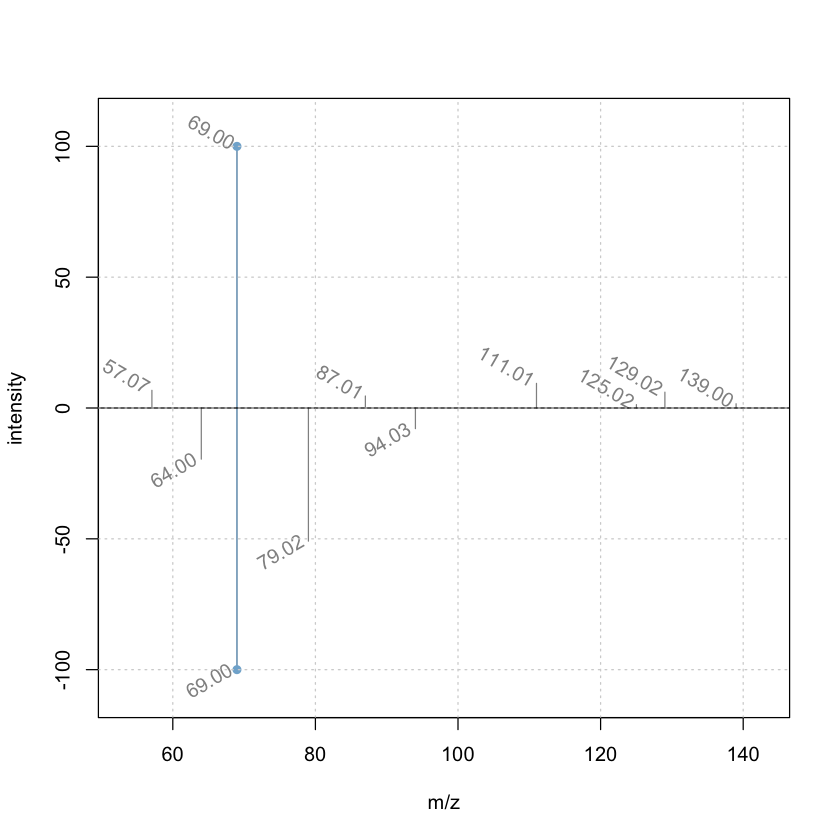

In [129]:
plotSpectraMirror(hmdb_sub[best_match[1]], test1, tolerance = 0.2,
                  labels = label_fun, labelPos = 2, labelOffset = 0.2,
                  labelSrt = -30)
grid()

In [113]:
length(has_mz)

[1] 64920

In [109]:
length(hmdb)

[1] 64920

# HMDB match

In [100]:
hmdb <- Spectra(cdb)

In [96]:
hmdb <- addProcessing(hmdb,norm_int)

In [101]:
#' Compare HMDB against experimental spectra
res <- compareSpectra(hmdb_sub, sps, tolerance = 0.2)

'MsBackendCompDb' does not support parallel processing. Switching to serial processing.



In [87]:
peaksData(sps_ms2)[[1L]]

mz,intensity
69.04339,8.310565
72.05448,25.751366
74.05808,12.204007
83.05890,9.836066
84.04286,21.698543
84.07975,14.184882
84.95779,8.515483
87.05397,9.858834
87.07830,38.524590
90.05327,100.000000


In [52]:
str(xdata_group)

Formal class 'XcmsExperiment' [package "xcms"] with 11 slots
  ..@ chromPeaks        : num [1:15065, 1:11] 115 417 540 647 662 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr [1:15065] "CP00001" "CP00002" "CP00003" "CP00004" ...
  .. .. ..$ : chr [1:11] "mz" "mzmin" "mzmax" "rt" ...
  ..@ chromPeakData     :'data.frame':	15065 obs. of  3 variables:
  .. ..$ ms_level : int [1:15065] 1 1 1 1 1 1 1 1 1 1 ...
  .. ..$ is_filled: logi [1:15065] FALSE FALSE FALSE FALSE FALSE FALSE ...
  .. ..$ merged   : logi [1:15065] FALSE FALSE FALSE FALSE FALSE FALSE ...
  ..@ featureDefinitions:'data.frame':	1850 obs. of  12 variables:
  .. ..$ mzmed        : num [1:1850] 64 69 69.1 72.1 73.1 ...
  .. ..$ mzmin        : num [1:1850] 64 69 69.1 72.1 73.1 ...
  .. ..$ mzmax        : num [1:1850] 64 69 69.1 72.1 73.1 ...
  .. ..$ rtmed        : num [1:1850] 170 228 323 169 170 ...
  .. ..$ rtmin        : num [1:1850] 164 221 321 164 164 ...
  .. ..$ rtmax        : num [1:1850] 173 230 325 173 

In [41]:
## feature grouping with different setting
featureDefinitions(xdata_group)$feature_group <- NULL

## Repeat the grouping
xdata_group <- groupFeatures(xdata_group, EicSimilarityParam(threshold = 0.7, n = 2))

Warning message in .local(object, ...):
"No chromatographic peaks present. Returning data as is"
Warning message in .local(object, ...):
"No chromatographic peaks present. Returning data as is"
Warning message in .local(object, ...):
"No chromatographic peaks present. Returning data as is"
Warning message in .local(object, ...):
"No chromatographic peaks present. Returning data as is"
Warning message in .local(object, ...):
"No chromatographic peaks present. Returning data as is"
Warning message in .local(object, ...):
"No chromatographic peaks present. Returning data as is"
Warning message in .local(object, ...):
"No chromatographic peaks present. Returning data as is"
Warning message in .local(object, ...):
"No chromatographic peaks present. Returning data as is"
Warning message in .local(object, ...):
"No chromatographic peaks present. Returning data as is"
Warning message in .local(object, ...):
"No chromatographic peaks present. Returning data as is"
Warning message in .local(obje

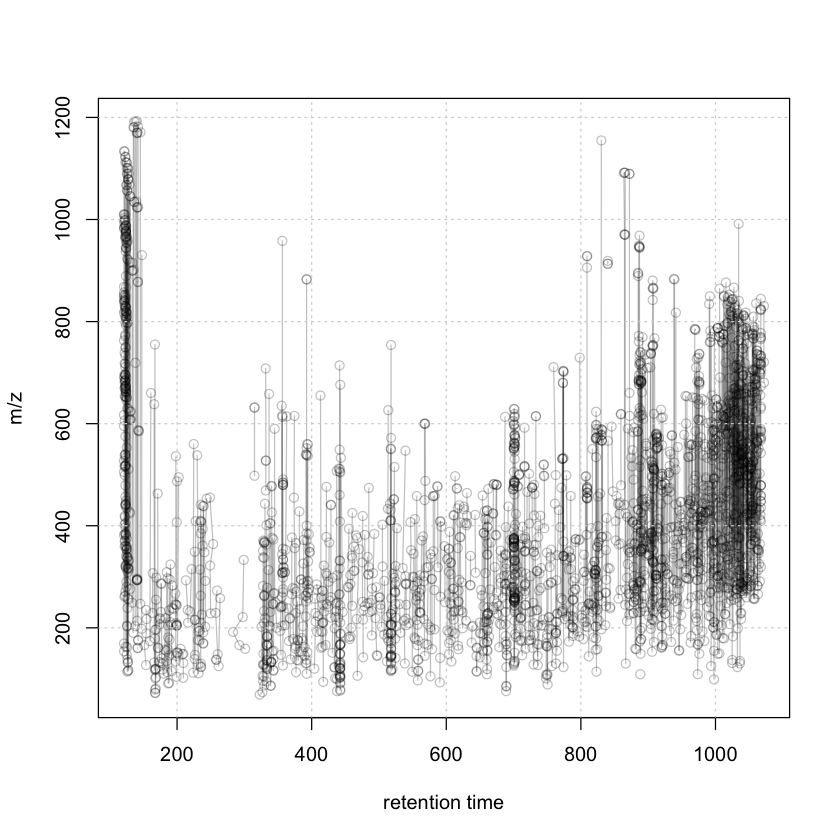

In [49]:
plotFeatureGroups(xdata_group, pch = 21, #lwd = 2, 
                  col = "#00000040"#, bg = "#00000020"
                )
grid()

In [51]:
fvals <- log2(featureValues(xdata_group, filled = TRUE))

# Check for missing values in fvals
any(is.na(fvals))

# If the above code returns TRUE, you might want to impute or remove them, for example:
fvals_imputed <- ifelse(is.na(fvals), 0, fvals)  # Replace NAs with 0


[1] TRUE

In [52]:
# Check for constant vectors in fvals
apply(fvals, 2, function(x) length(unique(x)) != 1)


KO-week16-1_20_01_13663.mzML   KO-week8-1_8_01_13669.mzML 
                        TRUE                         TRUE 
WT-week16-1_14_01_13684.mzML   WT-week8-1_2_01_13690.mzML 
                        TRUE                         TRUE

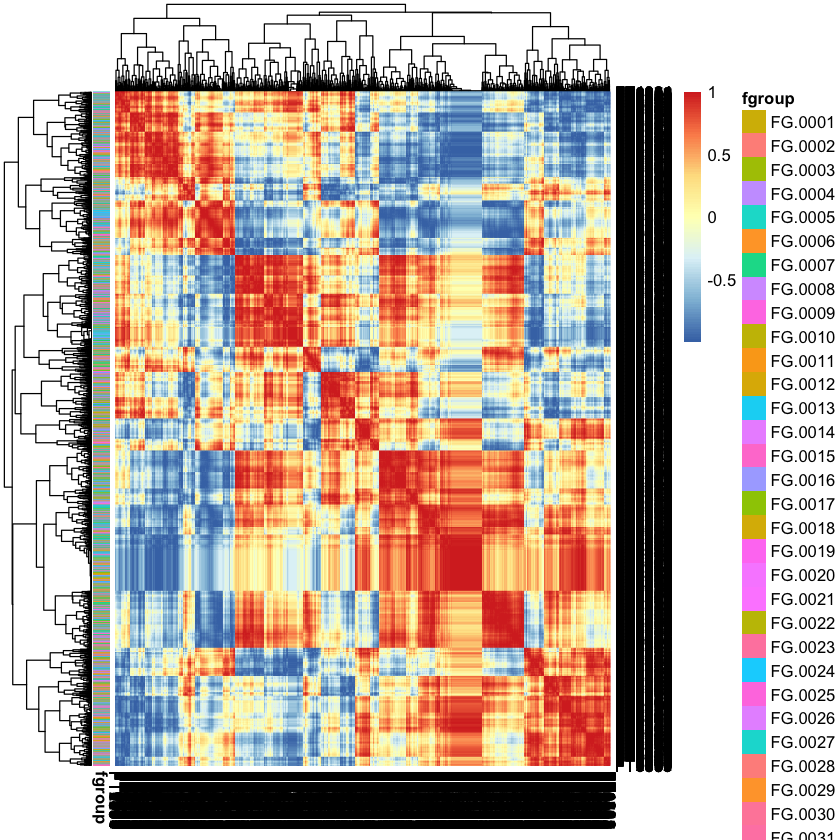

In [54]:

cormat <- cor(t(fvals_imputed), use = "pairwise.complete.obs")
ann <- data.frame(fgroup = featureGroups(xdata_group))
rownames(ann) <- rownames(cormat)

res <- pheatmap(cormat, annotation_row = ann, cluster_rows = TRUE,
                cluster_cols = TRUE)

In [55]:
xdata_group <- groupFeatures(
    xdata_group, AbundanceSimilarityParam(threshold = 0.7, transform = log2),
    filled = TRUE)
table(featureGroups(xdata_group))


FG.0001.001 FG.0001.002 FG.0002.001 FG.0002.002 FG.0002.003 FG.0003.001 
          5           1           2           1           1          13 
FG.0003.002 FG.0003.003 FG.0004.001 FG.0005.001 FG.0005.002 FG.0005.003 
          2           1           3           4           1           1 
FG.0005.004 FG.0005.005 FG.0006.001 FG.0007.001 FG.0007.002 FG.0008.001 
          1           1           3           6           4           2 
FG.0009.001 FG.0010.001 FG.0010.002 FG.0010.003 FG.0011.001 FG.0012.001 
          2           1           1           1           3           7 
FG.0012.002 FG.0013.001 FG.0013.002 FG.0013.003 FG.0013.004 FG.0014.001 
          1           1           1           1           1           7 
FG.0014.002 FG.0014.003 FG.0014.004 FG.0015.001 FG.0015.002 FG.0016.001 
          2           1           1           4           1           3 
FG.0017.001 FG.0017.002 FG.0018.001 FG.0018.002 FG.0018.003 FG.0019.001 
          3           1           1           1   

In [59]:
featureDefinitions(xdata_group)$feature_group <- NA_character_

set.seed(123)
fts_idx <- sample(1:nrow(featureDefinitions(xdata_group)), 10)
featureDefinitions(xdata_group)$feature_group[fts_idx] <- "FG"

In [60]:
xdata_group <- groupFeatures(xdata_group, SimilarRtimeParam(diffRt = 20))
xdata_group <- groupFeatures(xdata_group, AbundanceSimilarityParam(threshold = 0.7))
table(featureGroups(xdata_group))


FG.001.001 FG.001.002 FG.002.001 FG.002.002 FG.003.001 FG.003.002 FG.004.001 
         1          1          2          1          1          1          1 
FG.005.001 FG.006.001 
         1          1 

In [63]:
xdata_group <- filterMsLevel(xdata_group, msLevel = 2)

In [64]:
length(xdata_group)

[1] 7899

ERROR: Error in (function (classes, fdef, mtable) : impossible de trouver une m'ethode h'erit'ee pour la fonction 'filterIntensity' pour la signature '"XCMSnExp"'


In [65]:
writeMSData(xdata_group, file = "output.mzML")

ERROR: Error in .writeMSData(object = object, file = file, outformat = outformat, : length of 'file' has to match the number of samples


# test subsetting